Download & Prepare Data 
Feature Engineering
Data Cleaning
EDA
Feature Selection
Prepare Train & Test Data
Run Model : Random Forest
Run Model : ARIMA
Run Model : Linear Regression

In [3]:
from datetime import datetime
import os
from networkx import display
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [4]:
def download_data():
    if not os.path.exists("rdu_weather_data.csv") or not os.path.exists("rdu_weather_predict.csv"):
        X_start = datetime(2018, 1, 1)
        X_end = datetime(2025, 9, 16, 23, 59)
        y_start = datetime(2025, 9, 17)
        y_end = datetime(2025, 9, 30, 23, 59)

        print("Downloading RDU weather data, please wait...")
        from meteostat import Hourly
        X = Hourly('72306', X_start, X_end).fetch()
        y = Hourly('72306', y_start, y_end).fetch()
        X.to_csv("rdu_weather_data.csv", index=True)
        y.to_csv("rdu_weather_predict.csv", index=True)
        print("Downloaded and saved data!")
        return X, y
    else:
        print("You already have the weather data downloaded, not redownloading.")
        X = pd.read_csv("rdu_weather_data.csv", index_col=0, parse_dates=True)
        y = pd.read_csv("rdu_weather_predict.csv", index_col=0, parse_dates=True)
        return X, y

In [5]:
def prepare_data(X, y):
    # Convert index timezone from UTC to America/New_York (if timezone-naive, localize first)
    for df in [X, y]:
        # If index is timezone-naive (no tz), localize then convert.
        if df.index.tz is None:
            df.index = df.index.tz_localize("UTC").tz_convert("America/New_York")
        else:
            df.index = df.index.tz_convert("America/New_York")
    return X, y

In [6]:
X, y = download_data()
X, y = prepare_data(X, y)
print(X.head())

You already have the weather data downloaded, not redownloading.
                           temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
time                                                                        
2017-12-31 19:00:00-05:00  -3.9 -21.5  24.0   NaN   NaN  30.0  16.6   NaN   
2017-12-31 20:00:00-05:00  -3.9 -21.0  25.0   0.0   NaN  50.0  14.8   NaN   
2017-12-31 21:00:00-05:00  -3.9 -21.0  25.0   0.0   NaN  30.0  16.6   NaN   
2017-12-31 22:00:00-05:00  -4.4 -21.4  25.0   0.0   NaN  50.0  16.6   NaN   
2017-12-31 23:00:00-05:00  -5.0 -20.7  28.0   0.0   NaN  40.0  16.6   NaN   

                             pres  tsun  coco  
time                                           
2017-12-31 19:00:00-05:00  1027.4   NaN   NaN  
2017-12-31 20:00:00-05:00  1027.5   NaN   NaN  
2017-12-31 21:00:00-05:00  1028.0   NaN   NaN  
2017-12-31 22:00:00-05:00  1028.8   NaN   NaN  
2017-12-31 23:00:00-05:00  1029.3   NaN   NaN  


In [7]:
def build_features(X, make_datetime_col=False):
    """
    Build features. Accepts DataFrame X where timestamp is the index.
    If make_datetime_col=True, a 'datetime' column will be created from the index.
    """
    df = X.copy()

    # Converting datetime column to pandas.
    if 'time' in df.columns:
        df['datetime'] = pd.to_datetime(df['time'])

    # The below features decreased the R2 score drastically to negative (despite the strong correlation), which is why they are commented out.
    '''
    # Last hour & last day temperature
    df['temp_lag_1'] = df['temp'].shift(1)      
    df['temp_lag_24'] = df['temp'].shift(24)  
    df['1day_avg'] = df['temp'].rolling(window=24).mean()
    '''
    # Rolling averages (assumes hourly data)
    # 7 days, 3 day (72 hours), 30 day (720 hours)
    df['7day_avg'] = df['temp'].rolling(window=168, min_periods=1).mean()
    df['3day_avg'] = df['temp'].rolling(window=72, min_periods=1).mean()
    df['30day_avg'] = df['temp'].rolling(window=720, min_periods=1).mean()

    print(f"Data shape after feature engineering: {df.shape}")
    print(df.head())
    return df

In [8]:
df = build_features(X, make_datetime_col=False)

Data shape after feature engineering: (67584, 14)
                           temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt  \
time                                                                        
2017-12-31 19:00:00-05:00  -3.9 -21.5  24.0   NaN   NaN  30.0  16.6   NaN   
2017-12-31 20:00:00-05:00  -3.9 -21.0  25.0   0.0   NaN  50.0  14.8   NaN   
2017-12-31 21:00:00-05:00  -3.9 -21.0  25.0   0.0   NaN  30.0  16.6   NaN   
2017-12-31 22:00:00-05:00  -4.4 -21.4  25.0   0.0   NaN  50.0  16.6   NaN   
2017-12-31 23:00:00-05:00  -5.0 -20.7  28.0   0.0   NaN  40.0  16.6   NaN   

                             pres  tsun  coco  7day_avg  3day_avg  30day_avg  
time                                                                          
2017-12-31 19:00:00-05:00  1027.4   NaN   NaN    -3.900    -3.900     -3.900  
2017-12-31 20:00:00-05:00  1027.5   NaN   NaN    -3.900    -3.900     -3.900  
2017-12-31 21:00:00-05:00  1028.0   NaN   NaN    -3.900    -3.900     -3.900  
2017-12-31 22:0

In [ ]:
def robust_ffill_impute(df, sort_index=True, drop_all_nan_cols=True, verbose=True):
    """
    Robust forward-fill imputation pipeline:
      1. Ensure time order by sorting index .
      2. Forward-fill (ffill) then back-fill (bfill).
      3. Replace remaining numeric NaNs with column mean.
      4. Replace remaining non-numeric NaNs with mode.
      5. Optionally drop columns that are 100% NaN.

    Returns: df_imputed (copy)
    """
    df_imputed = df.copy()

    # Ensure index (datetime) is sorted 
    if sort_index:
        
            df_imputed.index = pd.to_datetime(df_imputed.index)
            df_imputed = df_imputed.sort_index()
   

    # Forward fill then back fill
    df_imputed = df_imputed.ffill().bfill()

    # Not requirded as ffill+bfill will handle NaNs
    '''
    # For numeric columns, fill remaining NaNs with column mean (may not be the most accurate way, should rather popualate with lag1 hourly values.)
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        means = df_imputed[numeric_cols].mean()
        df_imputed[numeric_cols] = df_imputed[numeric_cols].fillna(means)

    # For non-numeric columns, fill remaining NaNs with mode or fallback (may not be the most accurate way, should rather popualate with lag1 hourly values.)
    non_numeric_cols = [c for c in df_imputed.columns if c not in numeric_cols]
    for c in non_numeric_cols:
        if df_imputed[c].isna().any():
            mode_vals = df_imputed[c].mode(dropna=True)
            if not mode_vals.empty:
                df_imputed[c] = df_imputed[c].fillna(mode_vals.iloc[0])
            else:
                # no mode available; use placeholder
                df_imputed[c] = df_imputed[c].fillna("missing")
    '''
    # drop columns that are 100% NaN 
    if drop_all_nan_cols:
        all_nan_cols = df.columns[df.isna().all()].tolist()
        if all_nan_cols:
            if verbose:
                print(f"Dropping columns that are all-NaN and cannot be imputed: {all_nan_cols}")
            df_imputed = df_imputed.drop(columns=all_nan_cols)

    # 6) Final diagnostic
    total_remaining = int(df_imputed.isna().sum().sum())
    if verbose:
        print(f"Imputation done. Remaining NaNs in dataframe: {total_remaining}")
        if total_remaining > 0:
            print("NaN counts per column (top 10):")
            print(df_imputed.isna().sum().sort_values(ascending=False).head(10))

    return df_imputed



In [28]:
df_imputed = robust_ffill_impute(df, verbose=True)
print(df_imputed.head())  


Dropping columns that are all-NaN and cannot be imputed: ['snow', 'tsun']
Imputation done. Remaining NaNs in dataframe: 0
                           temp  dwpt  rhum  prcp  wdir  wspd  wpgt    pres  \
time                                                                          
2017-12-31 19:00:00-05:00  -3.9 -21.5  24.0   0.0  30.0  16.6  23.0  1027.4   
2017-12-31 20:00:00-05:00  -3.9 -21.0  25.0   0.0  50.0  14.8  23.0  1027.5   
2017-12-31 21:00:00-05:00  -3.9 -21.0  25.0   0.0  30.0  16.6  23.0  1028.0   
2017-12-31 22:00:00-05:00  -4.4 -21.4  25.0   0.0  50.0  16.6  23.0  1028.8   
2017-12-31 23:00:00-05:00  -5.0 -20.7  28.0   0.0  40.0  16.6  23.0  1029.3   

                           coco  7day_avg  3day_avg  30day_avg  month  season  
time                                                                           
2017-12-31 19:00:00-05:00  14.0    -3.900    -3.900     -3.900     12  Winter  
2017-12-31 20:00:00-05:00  14.0    -3.900    -3.900     -3.900     12  Winter  
2017

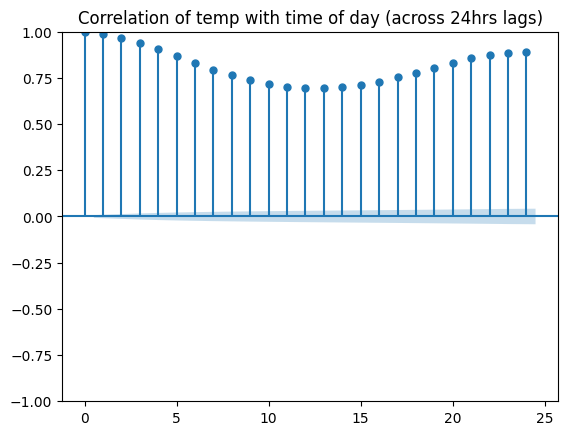

We see highest correlation at Lag1(1 hour) and Lag24(24 hours).


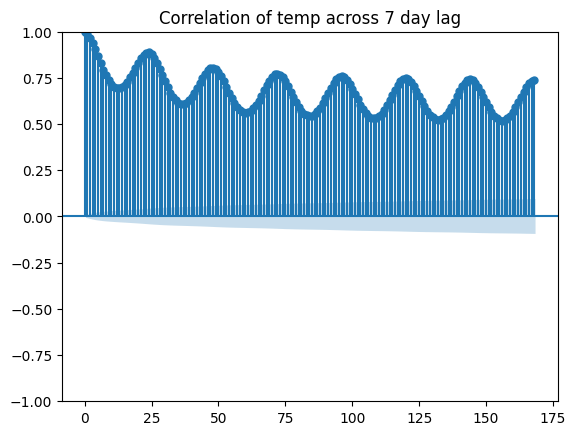

For a lag of 7 days, We see highest correlation at every 24 hours. This indicats a daily cycle.


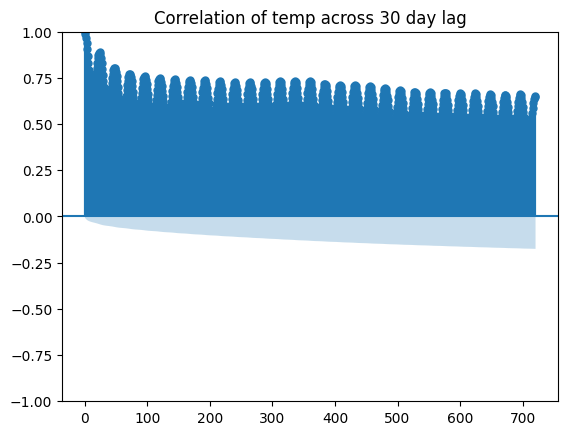

For a lag of 30 days,We see the daily cycle is still present but dips gradually.


In [ ]:
# Perform EDA
    
df_input_viz = df['temp']
plot_acf(df_input_viz,lags=24)
plt.title('Correlation of temp with time of day (across 24hrs lags)')
plt.show()
print('We see highest correlation at Lag1(1 hour) and Lag24(24 hours).')

plot_acf(df_input_viz,lags=168)
plt.title('Correlation of temp across 7 day lag')
plt.show()
print('For a lag of 7 days, We see highest correlation at every 24 hours. This indicats a daily cycle.')

plot_acf(df_input_viz,lags=720)
plt.title('Correlation of temp across 30 day lag')
plt.show()
print('For a lag of 30 days,We see the daily cycle is still present but dips gradually.')

<Figure size 1200x800 with 0 Axes>

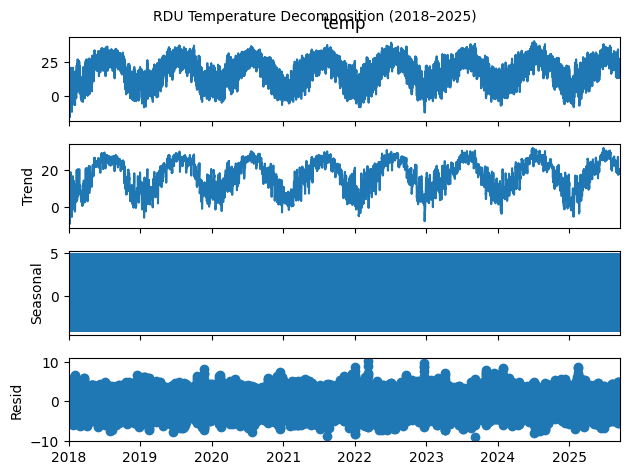

Trend shows an almost constant yearly trend with slight increase over years.
Seasonality is constant. Residuals appear to be stationary with mean around 0.


In [ ]:
# Perform time series decomposition

df_temp = df['temp'].copy()
df_temp = df_temp['2018-01-01':'2025-09-16']

# Ensure it's datetime-indexed
df_temp.index = pd.to_datetime(df_temp.index)
result = sm.tsa.seasonal_decompose(df_temp, model='additive', period=24)

# Plot
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('RDU Temperature Decomposition (2018–2025)', fontsize=10)
plt.show()
print('Trend shows an almost constant yearly trend with slight increase over years.')
print('Seasonality is constant. Residuals appear to be stationary with mean around 0.')

Windspeed:


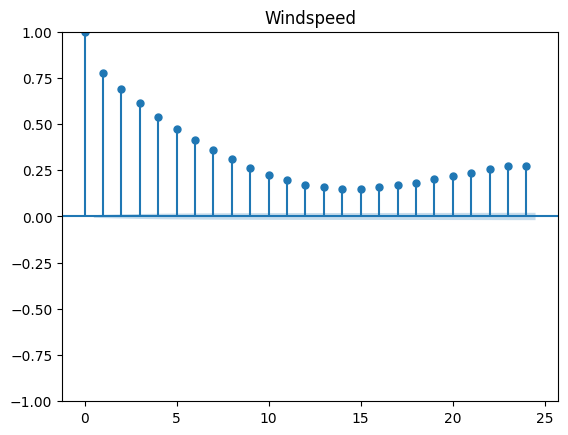

Windspeed has the highest correlation at lag of 1 hour. Corrlation decreases over time.
DewPoint:


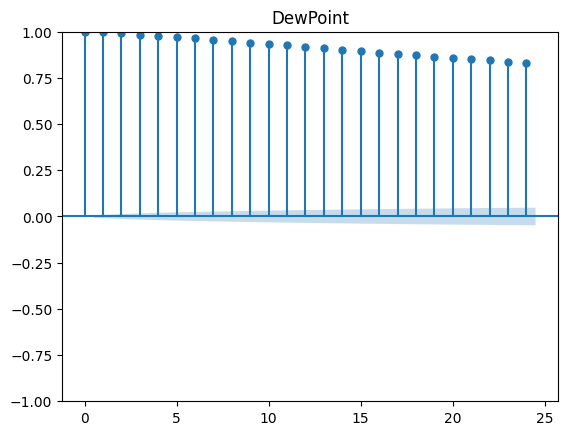

DewPoint has a high correlated with the highest being at lag of 5 hours.
DewPoint:


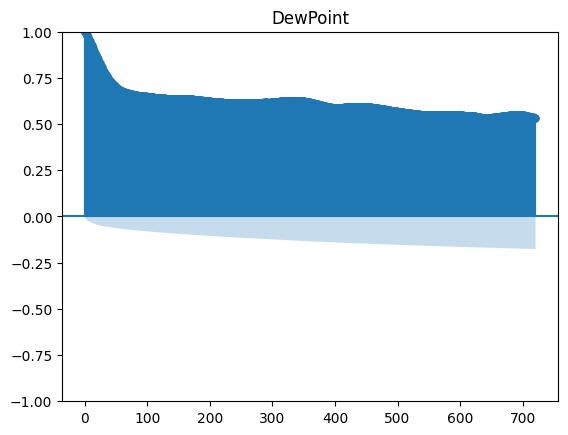

DewPoint has a high initial correlation (24hours) but decreses over time.


In [ ]:
# Cross-correlation analysis

#Windspeed
print('Windspeed:')
df_input_viz = df['wspd']
plot_acf(df_input_viz,lags=24)
plt.title('Windspeed')
plt.show()
print('Windspeed has the highest correlation at lag of 1 hour. Corrlation decreases over time.')

# DewPoint
print('DewPoint:')
df_input_viz = df['dwpt']
plot_acf(df_input_viz,lags=24)
plt.title('DewPoint')
plt.show()
print('DewPoint has a high correlated with the highest being at lag of 5 hours.')

#30 day lag
print('DewPoint:')
df_input_viz = df['dwpt']
plot_acf(df_input_viz,lags=720)
plt.title('DewPoint')
plt.show()
print('DewPoint has a high initial correlation (24hours) but decreses over time.')

<Figure size 800x300 with 0 Axes>

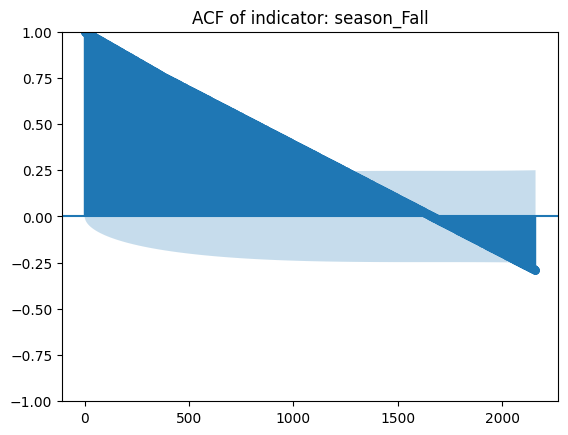

<Figure size 800x300 with 0 Axes>

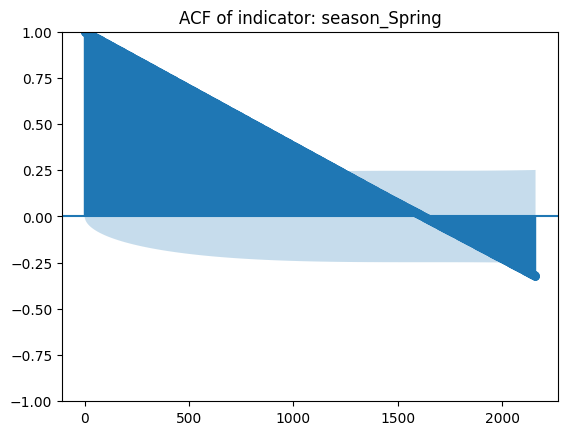

<Figure size 800x300 with 0 Axes>

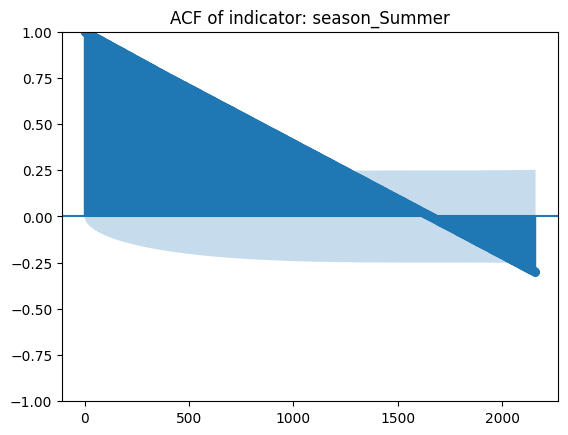

<Figure size 800x300 with 0 Axes>

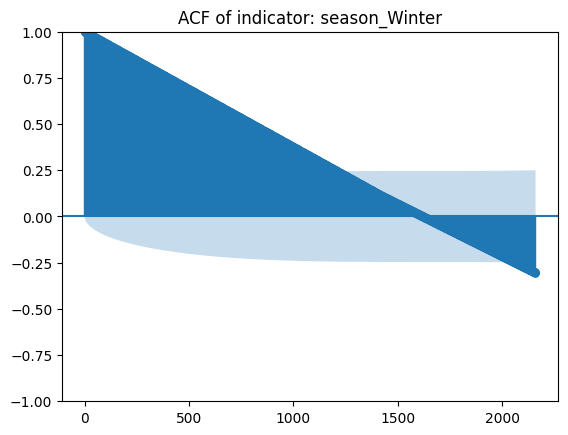

Each season lasts about 90 days (3 months), so the correlation gradually transitions from 1 (high at lag 0) to 0 (lag 60days) to negative at lag 90 days as it is the next season.


In [ ]:
# Correlation and Feature creation based on the season

# ensure index is datetime
df.index = pd.to_datetime(df.index)

# add month
df['month'] = df.index.month

conditions = [
    df['month'].isin([12, 1, 2]),   # Winter
    df['month'].isin([3, 4, 5]),    # Spring
    df['month'].isin([6, 7, 8]),    # Summer
    df['month'].isin([9, 10, 11])   # Fall
]
choices = ['Winter', 'Spring', 'Summer', 'Fall']

# set default to a string (not 0)
df['season'] = np.select(conditions, choices, default='Unknown')

# convert to categorical for memory/performance
df['season'] = df['season'].astype('category')

season_dummies = pd.get_dummies(df['season'], prefix='season')

# example: plot ACF for each season indicator
for col in season_dummies.columns:
    plt.figure(figsize=(8,3))
    plot_acf(season_dummies[col], lags=2160)   # or smaller lags if preferred
    plt.title(f'ACF of indicator: {col}')
    plt.show()
print('Each season lasts about 90 days (3 months), so the correlation gradually transitions from 1 (high at lag 0) to 0 (lag 60days) to negative at lag 90 days as it is the next season.')

In [ ]:
def select_features_univariate(df, target_col='temp', k=5, verbose=True):
    """
    Run SelectKBest after applying robust forward-fill imputation.
    Returns (final_df_train, selected_features, feature_scores)
    """
    df = df.copy()

    if target_col not in df.columns:
        raise KeyError(f"target_col '{target_col}' not found in dataframe.")

    # 1) Prepare numeric X and y
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    if len(numeric_cols) == 0:
        raise ValueError("No numeric feature columns found for selection after imputation.")

    X_numeric = df_imputed[numeric_cols]
    y_train = df_imputed[target_col]

    # Fit selector
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_numeric, y_train)

    # scores_ is aligned with X_numeric.columns
    feature_scores = pd.Series(selector.scores_, index=X_numeric.columns)
    support_mask = selector.get_support()
    selected_features = X_numeric.columns[support_mask].tolist()

    if verbose:
        print("\n---- Univariate Feature Scores (f_regression) ----")
        for feat, sc in feature_scores.sort_values(ascending=False).items():
            status = "SELECTED" if feat in selected_features else "rejected"
            print(f"{feat}: {sc:.4f}  {status}")
        print(f"\nSelected features ({len(selected_features)}): {selected_features}")

    final_X_train = df_imputed[selected_features]
    final_y_train = df_imputed[target_col]
    return final_X_train, final_y_train, selected_features, feature_scores

In [30]:
final_X_train, final_y_train, selected_features, feature_scores = select_features_univariate(df_imputed, target_col='temp', k=5, verbose=True)
print('Final y_train')
print(final_y_train.head())


---- Univariate Feature Scores (f_regression) ----
dwpt: 182175.8847  SELECTED
3day_avg: 160871.8626  SELECTED
7day_avg: 126792.6130  SELECTED
30day_avg: 97851.6353  SELECTED
pres: 10443.4951  SELECTED
wspd: 3758.6424  rejected
month: 2522.3447  rejected
wdir: 1988.6897  rejected
wpgt: 1462.4806  rejected
coco: 934.3396  rejected
rhum: 305.5703  rejected
prcp: 0.0017  rejected

Selected features (5): ['dwpt', 'pres', '7day_avg', '3day_avg', '30day_avg']
Final y_train
time
2017-12-31 19:00:00-05:00   -3.9
2017-12-31 20:00:00-05:00   -3.9
2017-12-31 21:00:00-05:00   -3.9
2017-12-31 22:00:00-05:00   -4.4
2017-12-31 23:00:00-05:00   -5.0
Name: temp, dtype: float64


In [31]:
def prepare_train_feats(final_X_train):
    '''
    Inputs:
    final_X_train(pd.DataFrame): pre preparation training input
    Ouputs:
    X_train_prep(pd.DataFrame): scaled training dataset
    '''
    scaler = MinMaxScaler()
    X_train_prep = scaler.fit_transform(final_X_train)
    print(f"Data shape of training data set: {X_train_prep.shape}")
    print(X_train_prep)
    print('final_X_train')
    print(final_X_train.head())
    
    return X_train_prep

In [32]:
X_train_prep = prepare_train_feats(final_X_train)

Data shape of training data set: (67584, 5)
[[0.01832994 0.7145488  0.08344861 0.08668265 0.08678423]
 [0.02851324 0.71639042 0.08344861 0.08668265 0.08678423]
 [0.02851324 0.72559853 0.08344861 0.08668265 0.08678423]
 ...
 [0.72505092 0.57826888 0.73038286 0.70219391 0.8030344 ]
 [0.72912424 0.57826888 0.72990391 0.70076232 0.80252302]
 [0.7311609  0.57826888 0.72942496 0.69968863 0.80203489]]
final_X_train
                           dwpt    pres  7day_avg  3day_avg  30day_avg
time                                                                  
2017-12-31 19:00:00-05:00 -21.5  1027.4    -3.900    -3.900     -3.900
2017-12-31 20:00:00-05:00 -21.0  1027.5    -3.900    -3.900     -3.900
2017-12-31 21:00:00-05:00 -21.0  1028.0    -3.900    -3.900     -3.900
2017-12-31 22:00:00-05:00 -21.4  1028.8    -4.025    -4.025     -4.025
2017-12-31 23:00:00-05:00 -20.7  1029.3    -4.220    -4.220     -4.220


In [ ]:
def prepar_test_feats(y,selected_features):
    '''
    Inputs:
    y: where y_start = datetime(2025, 9, 17) and y_end = datetime(2025, 9, 30, 23, 59)
    Ouputs:
    X_test_model, y_test_model(pd.DataFrame): scaled test dataset
    '''
    df = y.copy()
    df = build_features(df, make_datetime_col=False)
    df_imputed = robust_ffill_impute(df, verbose=True)
    X_test = df_imputed[selected_features]
    y_test = df_imputed['temp']
    y_test = y_test.reset_index(drop=True)
    scaler = MinMaxScaler()
    X_test_model = scaler.fit_transform(X_test)
    y_test_model = y_test.values

    print(f"Data shape of test data set: {X_test_model.shape}")
 
    print(f"Data shape of target test data set: {y_test_model.shape}")
  
    return X_test_model, y_test_model


In [35]:
X_test_model, y_test_model = prepar_test_feats(y,selected_features)

Data shape after feature engineering: (336, 14)
                           temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
time                                                                         
2025-09-16 20:00:00-04:00  17.0  13.1  78.0   0.0   NaN  330.0   6.0   NaN   
2025-09-16 21:00:00-04:00  17.0  13.7  81.0   0.0   NaN  340.0   6.0   NaN   
2025-09-16 22:00:00-04:00  17.0  13.5  80.0   0.0   NaN  320.0   6.0   NaN   
2025-09-16 23:00:00-04:00  17.0  13.1  78.0   0.0   NaN    0.0   0.0   NaN   
2025-09-17 00:00:00-04:00  17.0  13.1  78.0   0.0   NaN  340.0   6.0   NaN   

                             pres  tsun  coco  7day_avg  3day_avg  30day_avg  
time                                                                          
2025-09-16 20:00:00-04:00  1020.0   NaN   3.0      17.0      17.0       17.0  
2025-09-16 21:00:00-04:00  1020.0   NaN   3.0      17.0      17.0       17.0  
2025-09-16 22:00:00-04:00  1020.0   NaN   3.0      17.0      17.0       17.0  
2025-09-16

In [36]:
def run_model(X_train, y_train, X_test, y_test):
    '''
    Random Forest Regression model
    Inputs:
    X_train, y_train: training dataset
    X_test, y_test: test dataset
    Ouputs:
    mse, rmse,mae, r2: model performance metrics
    '''
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse,mae, r2

In [38]:
mse, rmse,mae, r2 = run_model(X_train_prep, final_y_train, X_test_model, y_test_model)
print('Root Mean Squared Error on the test set using Random Forest: {:.2f}'.format(rmse))
print('Predictions are off by ±11.44°F on average')
print('Mean Absolute Error on the test set using Random Forest: {:.2f}'.format(mae))
print('Predictions are off by ~9°F on average')
print(f"R2 Score: {r2:.4f}")
print('Model is ~6 times worse in predicting the mean temperature every time')

Root Mean Squared Error on the test set using Random Forest: 11.44
Predictions are off by ±11.44°F on average
Mean Absolute Error on the test set using Random Forest: 9.15
Predictions are off by ~9°F on average
R2 Score: -5.7960
Model is ~6 times worse in predicting the mean temperature every time


In [39]:
def run_model_sarima(X_train, y_train, X_test, y_test, order=(1,1,1)):
    '''
    SARIMA model
    Inputs:
    X_train, y_train: training dataset
    X_test, y_test: test dataset
    Ouputs:
    mse, rmse,mae, r2: model performance metrics
    '''
# Fit model
    model = sm.tsa.SARIMAX(y_train,
        order=(1,1,1)
    )
    fitted_model = model.fit(disp=False)

    steps = len(y_test)
    # get_forecast accepts exog for the forecast horizon
    forecast_res = fitted_model.get_forecast(steps=steps, exog=X_test)
    # predicted_mean is a numpy/pandas Series
    y_pred = forecast_res.predicted_mean

    # Ensure y_pred is a 1D numpy array for metrics
    y_pred_arr = np.asarray(y_pred).reshape(-1,)
 
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse,mae, r2

In [40]:
mse,rmse,mae,r2 = run_model_sarima(X_train_prep, final_y_train, X_test_model, y_test_model)
print('Mean Squared Error on the test set using SARIMAX: {:.2f}'.format(mse))
print('Root Mean Squared Error on the test set using SARIMAX: {:.2f}'.format(rmse))
print('Mean Absolute Error on the test set using SARIMAX: {:.2f}'.format(mae))
print(f"R2 Score: {r2:.4f}")

c:\Users\som\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\som\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Mean Squared Error on the test set using SARIMAX: 72.25
Root Mean Squared Error on the test set using SARIMAX: 8.50
Mean Absolute Error on the test set using SARIMAX: 7.27
R2 Score: -2.7513


In [ ]:
def run_model_linear(X_train, y_train, X_test, y_test):
    '''     
    Linear Regression model
    Inputs:
    X_train, y_train: training dataset
    X_test, y_test: test dataset
    Ouputs:
    mse: model performance metric
    '''

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse
  
   

In [42]:
mse_score = run_model_linear(X_train_prep, final_y_train, X_test_model, y_test_model)
print('Mean Squared Error on the test set using Linear Regression: {:.2f}'.format(mse_score))

Mean Squared Error on the test set using Linear Regression: 157.22
